In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import BstoK_ref_ff as BstoK
import h5py as h5
from tqdm import tqdm
import masses
from scipy.optimize import minimize_scalar
from numba import jit,float64,int8



In [2]:
datasetisrome = False

plustlist = [17,23.72835562]#20,
zerotlist = [17,20,23.72835562]

#[23.72835562, 21.15623588, 17.5]#np.array([23.7283556,22.11456,20.07895,17.5000000])#np.linspace(23.5,17.5,n)
maxplott = 24 #max(max(plustlist),max(zerotlist))+1
nplus = len(plustlist)
nzero = len(zerotlist)

def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

# define kinematics
mKphys		= masses.mK
mBsphys		= masses.mBs
#
qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

#
ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
Deltapar	= + 0.263
Deltaperp	= - 0.0416


f=h5.File('BstoK_ref_ff_dat.hdf5','r')
cp_BstoK=np.array(f.get('cp'))
c0_BstoK=np.array(f.get('c0'))
Cp0_BstoK=np.array(f.get('Cp0'))
fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)
# some IO

bskpts = np.r_[fp_BstoK,f0_BstoK]
bskcov = np.array(Cp0_ref)


chi0plus = 1.48e-02
chi1minus = 6.03e-04
chiplus = chi1minus
chizero = chi0plus

##### "Rome data" #####

romedata = np.array([[1.3461, 1.102, 0.911],
[1.6154, 1.208, 0.944],
[1.8846, 1.336, 0.979]]) #rome form factor data, plus = 1, zero = 2

romedataplus = np.array([[1.3461, 1.102],
[1.6154, 1.208],
[1.8846, 1.336]])

romedatazero = np.array([[1.3461, 0.911],
[1.6154, 0.944],
[1.8846, 0.979]])


######################################################################


tstar = 29.349571
t0 = 16.505107
tplus = 34.368484
tminus = 23.728356

dataplus=np.transpose(np.array([plustlist,
bskpts[0:nplus]]))

datazero=np.transpose(np.array([zerotlist,
bskpts[nplus:]]))

totaldata = [datazero,dataplus]
chizerovar = 0
chiplusvar = 0
eta = 1
covmatrix = bskcov
polevalszero = []
polevalsplus = [5.324700**2]

if datasetisrome:
    maxplott = 2
    datazero = romedatazero
    dataplus = romedataplus
    totaldata = [datazero,dataplus]
    #chizerovar = 0.00133
    #chiplusvar = 0.00036
    tminus = 1.8846
    tplus = 5.588946789081293
    tstar = tplus
    t0 = tminus
    eta = 2
    nplus=3
    nzero=3
    polevalszero = [2.3178**2]
    polevalsplus = [2.1122**2]
    covmatrix = np.array([[0.0003728 , 0.00035185, 0.00032986, 0.00062943, 0.00068001,
        0.00074066],
       [0.00035185, 0.00035141, 0.00035093, 0.00059243, 0.00066987,
        0.0007647 ],
       [0.00032986, 0.00035093, 0.00037308, 0.00055355, 0.00065922,
        0.00078995],
       [0.00062943, 0.00059243, 0.00055355, 0.00143986, 0.00165246,
        0.00191377],
       [0.00068001, 0.00066987, 0.00065922, 0.00165246, 0.0019623 ,
        0.00234545],
       [0.00074066, 0.0007647 , 0.00078995, 0.00191377, 0.00234545,
        0.00288136]])
    bskpts = []
    for subdata in [dataplus,datazero]:
        for counter in range(3):
            bskpts.append(subdata[counter,1])

In [3]:
def covresample(bskpts):
    bskpts_resampled = np.random.multivariate_normal(bskpts,covmatrix)
    dataplustlist = []
    for i in range(len(dataplus)):
        dataplustlist.append(dataplus[i][0])
    
    plus = np.array([dataplustlist,
    bskpts_resampled[0:nplus]])
    plus=np.transpose(plus)

    datazerotlist = []
    for i in range(len(datazero)):
        datazerotlist.append(datazero[i][0])
    zero = np.array([datazerotlist,
    bskpts_resampled[nplus:]])
    zero=np.transpose(zero)
    return [zero,plus]

In [4]:
def z(t):
    return (np.sqrt(tstar-t)-np.sqrt(tstar - t0))/(np.sqrt(tstar-t)+np.sqrt(tstar - t0))

In [5]:
def phiplus(t,chi = chiplus):
    #chi = 1
    K = 48*np.pi
    a = 3
    b = 2
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalsplus)):
        val *= (z(t)-z(polevalsplus[i]))/(1-np.conjugate(z(polevalsplus[i]))*z(t))
    return val

In [7]:
def phizero(t,chi = chizero):
    #chi = 1
    K = 16*np.pi/(tplus*tminus)
    a = 1
    b = 1
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalszero)):
        val *= (z(t)-z(polevalszero[i]))/(1-np.conjugate(z(polevalszero[i]))*z(t))
    return val

In [8]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [9]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    #print(row)
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [10]:
def Gdiag(G):
    #print(G)
    tempresult = np.linalg.svd(G)
    D = np.diag(tempresult[1])
    U = np.transpose(np.array(tempresult[0]))
    return [D,U]

In [11]:
def alpha(data,t):
    ssum = 0.0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        ssum += U[i,0]*U[i,0]/D[i,i]
    return ssum

In [12]:
def beta(data, t, phi,chi):
    ssum = 0.0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum += U[i,j]*data[j-1,1]*phi(data[j-1,0],chi)*U[i,0]/D[i,i]
    return ssum

In [13]:
def gamma(data, t,phi,chi):
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    ssum = 1.0
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            for k in range(1,data.shape[0]+1):
                ssum -= U[i,j]*data[j-1,1]*phi(data[j-1,0],chi)*U[i,k]*data[k-1,1]*phi(data[k-1,0],chi)/D[i,i]
    return ssum

In [14]:
def formfactor_unordered(data,t,chi=[chizero,chiplus]):
    results = []
    datazero = data[0]
    dataplus = data[1]
    chizero = chi[0]
    chiplus = chi[1]
    
    
    for dindex in [0,1]:
        ssum = 0.0
        tempdata = data[dindex]
        phi = [phizero,phiplus][dindex]
        
        
        calcalpha = alpha(tempdata,t)
        #print(tempdata,t,phi,chi[dindex])
        calcbeta = beta(tempdata,t,phi,chi[dindex])
        calcgamma = gamma(tempdata,t,phi,chi[dindex])
        #print(calcalpha,calcbeta,calcgamma)
        [D,U] = Gdiag(G(tempdata,t))
        #print(D,U)
        phif = tempdata[:,1]*phi(tempdata[:,0])
        for i in range(0,tempdata.shape[0]):
            for j in range(i+1,tempdata.shape[0]+1):
                for k in range(1,tempdata.shape[0]+1):
                    #print(U.shape,phif.shape)
                    C1 = 2*U[i,0]*U[i,k]*U[j,0]*U[j,1:]
                    C2 = U[i,0]*U[i,0]*U[j,k]*U[j,1:]
                    C3 = U[j,0]*U[j,0]*U[i,k]*U[i,1:]
                    ssum += phif[:]*phif[k-1]*(C1 - C2 - C3)/(D[i,i]*D[j,j]) # add to list and sort
        discrim = sum(ssum) + calcalpha
        if discrim < 0:
            print("discriminant is negative: ",discrim,calcbeta**2+calcalpha*calcgamma)
            discrim = 0
        lowerbound = (-calcbeta-np.sqrt(discrim))/(calcalpha*phi(t))
        upperbound = (-calcbeta+np.sqrt(discrim))/(calcalpha*phi(t))
        results.append([lowerbound,upperbound])
    return results

In [15]:
def sort_list(numlist):
    return np.flip(sorted(numlist, key = abs))

In [16]:
def formfactor(data,t,chi=[chizero,chiplus],poslist = None,neglist = None,dindex = [0,1]):#,optimize = False
    results = []
    datazero = data[0]
    dataplus = data[1]
    chizero = chi[0]
    chiplus = chi[1]
    
    for dindex in dindex:
        ssum = []
        tempdata = data[dindex]
        phi = [phizero,phiplus][dindex]
        
        
        calcalpha = alpha(tempdata,t)
        #print(tempdata,t,phi,chi[dindex])
        calcbeta = beta(tempdata,t,phi,chi[dindex])
        #calcgamma = gamma(tempdata,t,phi,chi[dindex])
        #print(calcalpha)#,calcbeta,calcgamma
        [D,U] = Gdiag(G(tempdata,t))
        #print(D,U)
        phif = tempdata[:,1]*phi(tempdata[:,0])
        for i in range(0,tempdata.shape[0]):
            for j in range(i+1,tempdata.shape[0]+1):
                for k in range(1,tempdata.shape[0]+1):
                    for l in range(1,tempdata.shape[0]+1):
                        #print(U.shape,phif.shape)
                        C1 = 2.0*U[i,0]*U[i,k]*U[j,0]*U[j,l]
                        C2 = U[i,0]*U[i,0]*U[j,k]*U[j,l]
                        C3 = U[j,0]*U[j,0]*U[i,k]*U[i,l]
                        ssum.append(phif[l-1]*phif[k-1]*(C1 - C2 - C3)/(D[i,i]*D[j,j]))  # add to list and sort
        ssum.append(calcalpha)
        summand = sort_list(ssum)
        discrim = 0.0
        for i in range(len(ssum)):
            discrim += summand[i]
        #print("Order of magnitude diff = ",np.log10(abs(summand[0])),np.log10(abs(summand[-1])),np.log10(abs(discrim)))
        if discrim < 0:
            if neglist is not None:
                neglist.append([np.log10(abs(summand[0])),discrim,dindex])
            #print("^discriminant is negative: ",discrim)
        elif poslist is not None:
            poslist.append([np.log10(abs(summand[0])),discrim,dindex])
        
        if abs(discrim/summand[0]) < 10**-10:
            discrim = 0.0
        #print([D,U])
        lowerbound = (-calcbeta-np.sqrt(discrim))/(calcalpha*phi(t))
        upperbound = (-calcbeta+np.sqrt(discrim))/(calcalpha*phi(t))
        results.append([lowerbound,upperbound])
    
    
    
    return results

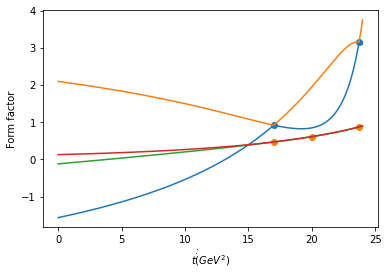

In [17]:
x = np.linspace(0,maxplott,1001)
plt.plot(x,[formfactor(totaldata,i)[1] for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(totaldata,i)[0] for i in x],label = r"$f_0$")
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
#plt.legend()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

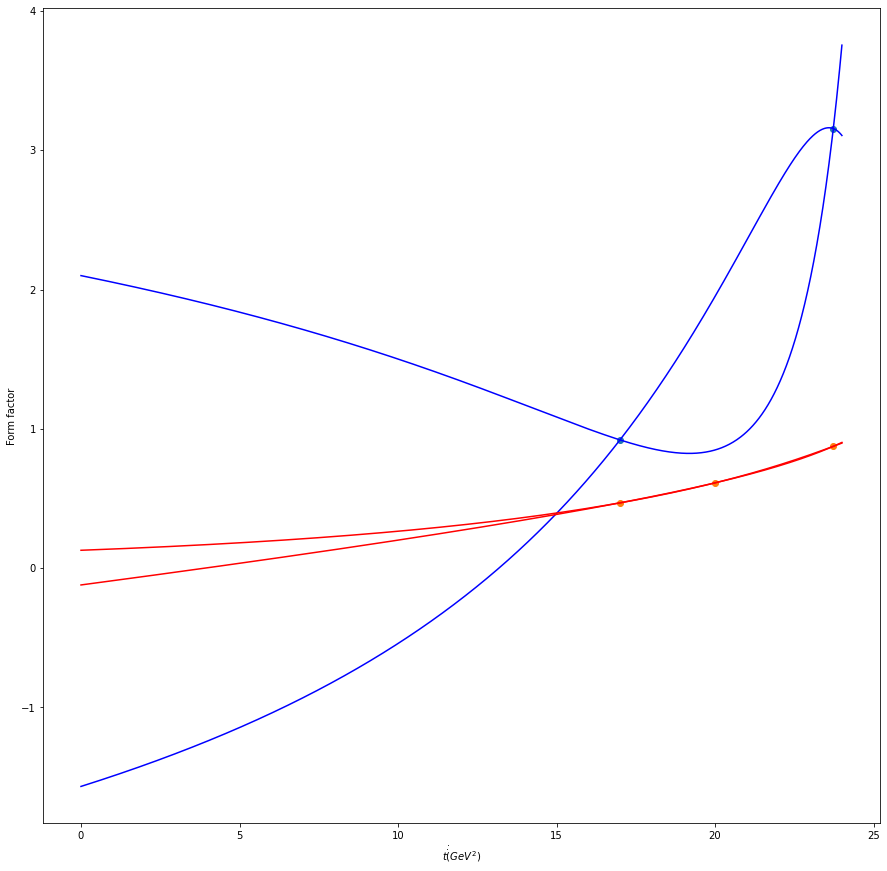

In [18]:
x = np.linspace(0,maxplott,1001)
plt.plot(x,[formfactor(totaldata,i)[1] for i in x],label = r"$f_+$",color = "blue")
plt.plot(x,[formfactor(totaldata,i)[0] for i in x],label = r"$f_0$",color = "red")
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
#plt.legend()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [19]:
def ff_datastacker(fval,resampleddata,t,chi,dindex,uplo):
    erdata = [0.0,0.0]
    erdata[0] = np.vstack([resampleddata[0],[0,fval]])
    erdata[1] = np.vstack([resampleddata[1],[0,fval]])
    #print(erdata,t,chi,[dindex])
    return (-1)**uplo * formfactor(erdata,t,chi,dindex = [dindex])[0][uplo]

In [20]:
def dispbounds(tlist,Nboot,N0=10,keepallindexresults=False,seed=None,NSdebug = False):
    np.random.seed(seed=seed)
    if N0 is not None and N0 < 2 :
        print("N0 must have a value of at least 2")
        return
    
    if NSdebug == True:
        poslist = []
        neglist = []
    else:
        poslist = None
        neglist = None
    
    nooverlapcount = 0
    unitarityfailcount = 0
    totalresults = []
    poslist = []
    neglist = []
    for i in tqdm(range(Nboot)):
        #print(bskpts)
        resampleddata = covresample(bskpts)
        #print(resampleddata)
        resampledchi = [np.random.normal(chizero,0),np.random.normal(chiplus,0)]#chizerovar,chiplusvar
        #print("about to resample zero bounds")
        resamplezerobounds = formfactor(resampleddata,0,resampledchi)#,poslist = poslist, neglist = neglist
        #print("finished resampling zero bounds")
        if resamplezerobounds[0][0]>resamplezerobounds[1][1] or resamplezerobounds[0][1]<resamplezerobounds[1][0]:
            #print("No Overlap")
            nooverlapcount += 1
            continue
        elif resamplezerobounds[0][0]==resamplezerobounds[0][1] or resamplezerobounds[1][0]==resamplezerobounds[1][1]:
            unitarityfailcount += 1
            continue
        lower = max(resamplezerobounds[0][0],resamplezerobounds[1][0])
        upper = min(resamplezerobounds[0][1],resamplezerobounds[1][1])
        
        
        #print(indexlist)
        
        if N0 == None:
            results = []
            for tindex in range(len(tlist)):
                t = tlist[tindex]
                optimizedresult = []
                for dindex in [0,1]:
                    tempoptimizeresults = []
                    for uplo in [0,1]:
                        #print(resampleddata,t,resampledchi,dindex,uplo)
                        optimized = minimize_scalar(ff_datastacker,bounds=(lower,upper),method='bounded', args=(resampleddata,t,resampledchi,dindex,uplo))
                        bound = (-1)**uplo * optimized.fun
                        #print(bound)
                        tempoptimizeresults.append(bound)
                    
                    optimizedresult.append(tempoptimizeresults)
                results.append(optimizedresult)
        else:
            indexlist = np.linspace(0,N0-1,N0,dtype=int)#index can take values from 0 to N0-1
            tempboundslist = np.zeros([len(tlist),len(indexlist)],dtype=object)
            for index in indexlist:
                fval = lower+(upper-lower)*index/(N0-1)
                erdata = [0,0]
                #print(resampleddata[0],resampleddata[1])
                erdata[0] = np.vstack([resampleddata[0],[0,fval]])
                erdata[1] = np.vstack([resampleddata[1],[0,fval]])
                counter = 0
                #print(erdata)
                for t in tlist:
                    tempbounds = formfactor(erdata,t,resampledchi,poslist = poslist, neglist = neglist)
                    tempboundslist[counter,index] = tempbounds
                    counter += 1
            #print(tempboundslist)
            if keepallindexresults==False:
                results = np.zeros([len(tlist)],dtype=object)
                for tindex in range(len(tlist)):
                    #print(tindex)
                    results[tindex] = tempboundslist[tindex,0]
                    for index in range(1,len(indexlist)):
                        a = results[tindex]
                        b = tempboundslist[tindex,index]
                        results[tindex] = [[np.nanmin([a[0][0],b[0][0]]),np.nanmax([a[0][1],b[0][1]])],[np.nanmin([a[1][0],b[1][0]]),np.nanmax([a[1][1],b[1][1]])]]
            elif keepallindexresults==True:
                results = tempboundslist #results structured as results[index][timeindex][f0/f+][lower/upper]

        totalresults.append(results)#results structured as results[Nboot][index][timeindex][f0/f+][lower/upper]
    if nooverlapcount + unitarityfailcount > 0:
        print(nooverlapcount,unitarityfailcount)
    
    if len(poslist)+len(neglist) > 0 and NSdebug == True:
        for dindex in [0,1]:
            plt.scatter([x[0] for x in poslist if x[2] == dindex],[x[1] for x in poslist if x[2] == dindex])
            plt.scatter([x[0] for x in neglist if x[2] == dindex],[x[1] for x in neglist if x[2] == dindex])
    #         maxx = max(max([x[0] for x in poslist if x[2] == dindex]),max([x[0] for x in neglist if x[2] == dindex]))
    #         minx = min(min([x[0] for x in poslist if x[2] == dindex]),min([x[0] for x in neglist if x[2] == dindex]))
    #         plt.hist([x[0] for x in poslist if x[2] == dindex],bins=20,range = (minx,maxx),color="blue", alpha=0.5)
    #         plt.hist([x[0] for x in neglist if x[2] == dindex],bins=20,range = (minx,maxx),color="red", alpha=0.5)
            plt.show()
    return [tlist,totalresults,Nboot-nooverlapcount]

In [21]:
#calculating final values from bootstrap results
def calcbounds(output):
    results = np.zeros([len(output[0]),2],dtype=object)
    for tindex in range(len(output[0])):
        tempresult=[]
        for dindex in [0,1]:
            tchosen = output[0][tindex]
            data = np.zeros([output[2],2])
            for boot in range(output[2]):
                data[boot,0] = output[1][boot][tindex][dindex][0]
                data[boot,1] = output[1][boot][tindex][dindex][1]
            #print(data)
            averageff = (0.5*(np.nanmean(data[:,0])+np.nanmean(data[:,1])))
            delta = [data[:,0]-averageff,data[:,1]-averageff]
            varlo = np.nansum(delta[0]**2)/(len(delta[0])-1)
            varup = np.nansum(delta[1]**2)/(len(delta[1])-1)
            rho = np.nansum(delta[0]*delta[1])/(len(delta[0])-1)
            #print(np.nanmean(data[:,0]),np.nanmean(data[:,1]),varlo,varup,rho)
            var = (np.nanmean(data[:,0])-np.nanmean(data[:,1]))**2/12 + (varlo+varup+rho)/3
            std = np.sqrt(var)
            tempresult.append([averageff,std])
        results[tindex,0] = output[0][tindex]
        results[tindex,1] = tempresult
    
    tvals = np.zeros([len(results[:,0])])
    f0vals = np.zeros([len(results[:,0])])
    f0vars = np.zeros([len(results[:,0])])
    fplusvals = np.zeros([len(results[:,0])])
    fplusvars = np.zeros([len(results[:,0])])
    for tindex in range(len(results[:,0])):
        tvals[tindex] = results[tindex,0]
        f0vals[tindex] = results[:,1][tindex][0][0]
        f0vars[tindex] = results[:,1][tindex][0][1]
        fplusvals[tindex] = results[:,1][tindex][1][0]
        fplusvars[tindex] = results[:,1][tindex][1][1]
    return [tvals,f0vals,f0vars,fplusvals,fplusvars]

In [22]:
# x = np.linspace(0,maxplott,101)
# resampleddata = covresample(bskpts)
# plt.plot(x,[formfactor(resampleddata,i)[1] for i in x],label = r"$f_+$")
# plt.plot(x,[formfactor(resampleddata,i)[0] for i in x],label = r"$f_0$")
# plt.scatter(resampleddata[1][:,0],resampleddata[1][:,1])
# plt.scatter(resampleddata[0][:,0],resampleddata[0][:,1])

# plt.xlabel(r"$t \.\.(GeV^2)$")
# plt.ylabel("Form factor")
# plt.legend()
# plt.rcParams["figure.figsize"] = (20,20)
# plt.show()

In [23]:
# #investigating index
# np.random.seed(seed=1)
# NBoot = 1
# N0 = 1000
# tlist = [10]
# output = dispbounds(tlist,NBoot,N0=N0,keepallindexresults=True,seed=2)#,seed=2,NSdebug = True

In [24]:
# fftoplot = 0 #0=f0, 1 = f+
# N0plotrange = range(N0)
# for t in range(len(tlist)):
#     for x in range(NBoot):
#         for bound in [0,1]:
#             plt.plot(N0plotrange,[output[1][x][t][i][fftoplot][bound] for i in N0plotrange])#,label=str(t)/output[1][x][t][0][fftoplot][bound]

# plt.xlabel("Index Value")
# plt.ylabel("Form Factor")
# #plt.legend()
# plt.rcParams["figure.figsize"] = (10,10)
# plt.show()

In [25]:
# fftoplot = 0 #0=f0, 1 = f+
# N0plotrange = range(N0)
# for t in range(len(tlist)):
#     for x in range(NBoot):
#         for bound in [0,1]:
#             plt.plot(N0plotrange,[output[1][x][t][i][fftoplot][bound] for i in N0plotrange])#,label=str(t)/output[1][x][t][0][fftoplot][bound]

# plt.xlabel("Index Value")
# plt.ylabel("Form Factor")
# #plt.legend()
# plt.rcParams["figure.figsize"] = (10,10)
# plt.show()

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


(2,)


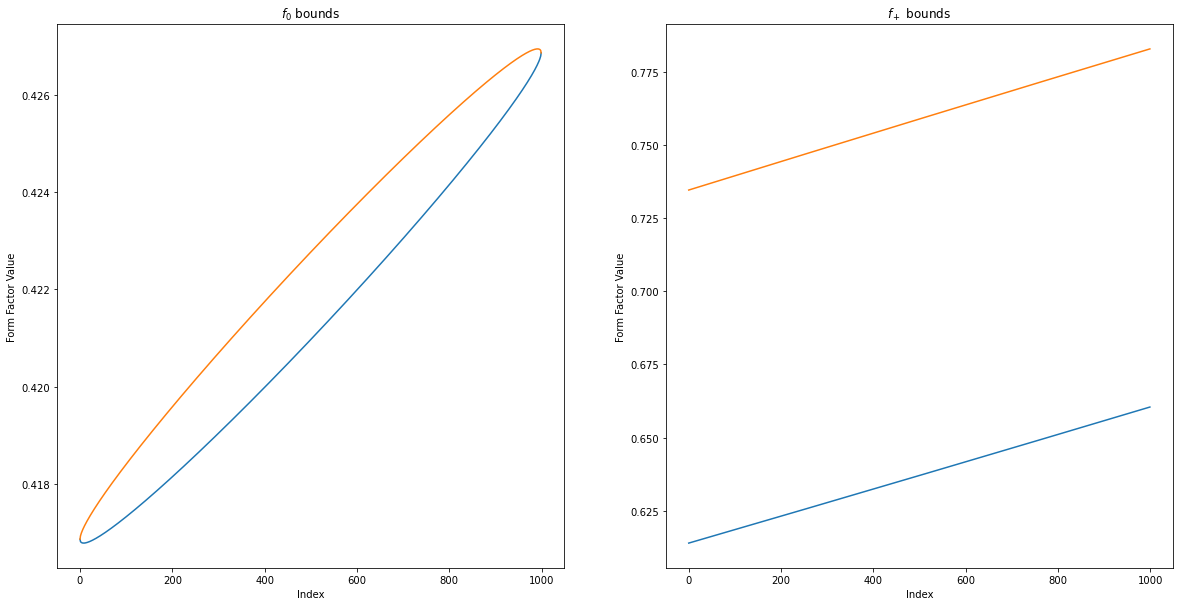

In [26]:
#investigating index
np.random.seed(seed=1)
NBoot = 1
N0 = 1000
tlist = [15]
output = dispbounds(tlist,NBoot,N0=N0,keepallindexresults=True,seed=2)#,seed=2,NSdebug = True

plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(1, 2)

#fftoplot = 0 #0=f0, 1 = f+
#N0start = int(N0/10)
N0plotrange = range(N0)
#print(N0plotrange)
print(np.shape(axs))
for j in [0,1]:
    for t in range(len(tlist)):
        for x in range(NBoot):
            for bound in [0,1]:
                axs[j].plot(N0plotrange,[output[1][x][t][i][j][bound] for i in range(N0)])#,label=str(t)/output[1][x][t][0][fftoplot][bound]
                axs[j].set_title(r"$f_{}$ bounds".format(("+" if j == 1 else "0")))
plt.xlabel("Index Value")
plt.ylabel("Form Factor")

for ax in axs.flat:
    ax.set(xlabel="Index", ylabel=r"Form Factor Value")
        
# for ax in axs.flat:
#     ax.label_outer()

plt.show()

In [27]:
# fftoplot = 0 #0=f0, 1 = f+
# N0start = int(N0/10)
# N0plotrange = range(N0)[0:N0start]
# print(N0plotrange)
# for t in range(len(tlist)):
#     for x in range(NBoot):
#         for bound in [0,1]:
#             plt.plot(N0plotrange,[output[1][x][t][i][fftoplot][bound] for i in N0plotrange])#,label=str(t)/output[1][x][t][0][fftoplot][bound]

# #plt.xlabel(r"$t \.\.(GeV^2)$")
# #plt.ylabel("Form factor")
# plt.legend()
# plt.rcParams["figure.figsize"] = (10,10)
# plt.show()

In [28]:
output

[[15],
 [array([[list([[0.41687430143348597, 0.41687430143348597], [0.6140409324559721, 0.7345405910195215]]),
          list([[0.4168275263299996, 0.41694105944233467], [0.6140868082296452, 0.7345894170732887]]),
          list([[0.416814044535692, 0.4169745241420045], [0.6141326852430189, 0.7346382418873555]]),
          list([[0.41680605180096425, 0.4170024997820947], [0.6141785634960023, 0.7346870654618122]]),
          list([[0.41680090490110167, 0.4170276295873196], [0.6142244429885045, 0.7347358877967503]]),
          list([[0.4167975794501767, 0.41705093794360704], [0.6142703237204348, 0.7347847088922603]]),
          list([[0.41679554980904693, 0.4170729504900991], [0.6143162056917023, 0.7348335287484332]]),
          list([[0.41679450356574904, 0.4170939796387592], [0.6143620889022166, 0.7348823473653594]]),
          list([[0.4167942370647003, 0.4171142290451705], [0.6144079733518867, 0.7349311647431293]]),
          list([[0.4167946087760148, 0.4171338402392183], [0.6144538

In [29]:
# timelist = np.linspace(0,maxplott,11)#[10]#[17.5,21.15623588,23.72835562]
# NBootstraps = 10
# output = dispbounds(timelist,NBootstraps,N0=None)

In [30]:
# final = calcbounds(output)
# tvals = final[0]
# f0vals = final[1]
# f0vars = final[2]
# fplusvals = final[3]
# fplusvars = final[4]


# plt.scatter(dataplus[:,0],dataplus[:,1])
# plt.scatter(datazero[:,0],datazero[:,1])
# plt.plot(tvals,f0vals,label = r"$f_0$",color="orange")
# plt.fill_between(tvals,f0vals-f0vars,f0vals+f0vars,linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
# plt.plot(tvals,fplusvals,label = r"$f_+$",color="lightskyblue")
# plt.fill_between(tvals,fplusvals-fplusvars,fplusvals+fplusvars,linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

# plt.xlabel(r"$t \.\. (GeV^2)$")
# plt.ylabel("Form factor")
# plt.legend()
# plt.rcParams["figure.figsize"] = (25,15)
# plt.show()

In [31]:
timelist = np.linspace(0,23.72835562,10)#[10]#[17.5,21.15623588,23.72835562]
NBootstraps = 200
output = dispbounds(timelist,NBootstraps,N0=2)

100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


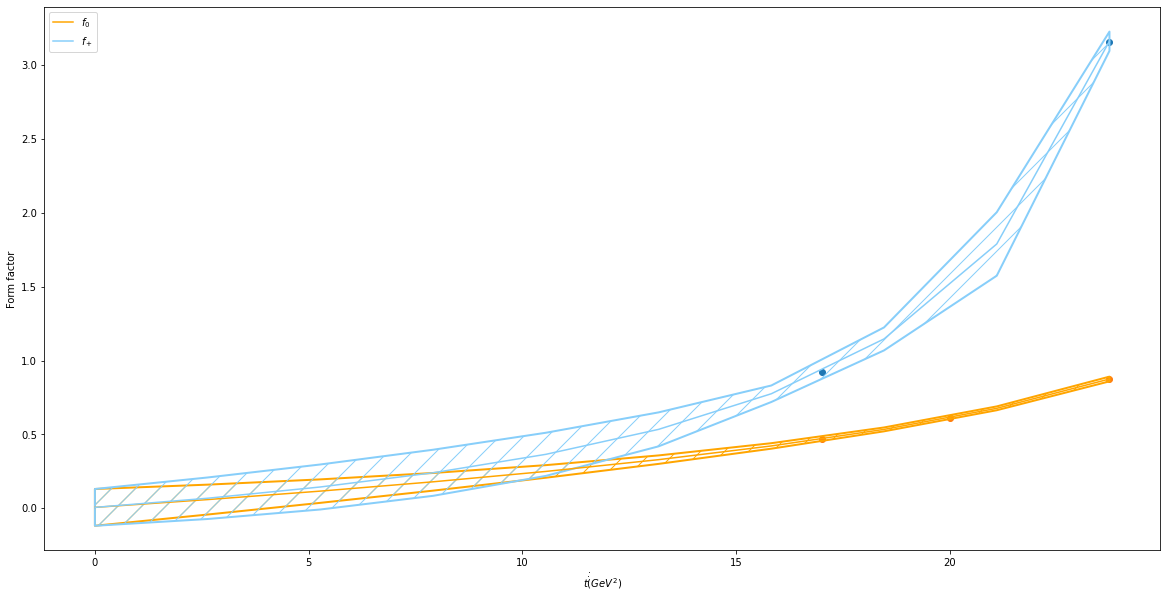

In [32]:
final = calcbounds(output)
tvals = final[0]
f0vals = final[1]
f0vars = final[2]
fplusvals = final[3]
fplusvars = final[4]


plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])
plt.plot(tvals,f0vals,label = r"$f_0$",color="orange")
plt.fill_between(tvals,f0vals-f0vars,f0vals+f0vars,linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(tvals,fplusvals,label = r"$f_+$",color="lightskyblue")
plt.fill_between(tvals,fplusvals-fplusvars,fplusvals+fplusvars,linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [33]:
timelist = np.linspace(0,24,97)#[10]#[17.5,21.15623588,23.72835562]
NBootstraps = 2000
output = dispbounds(timelist,NBootstraps,N0=2)

100%|██████████| 2000/2000 [25:52<00:00,  1.29it/s]


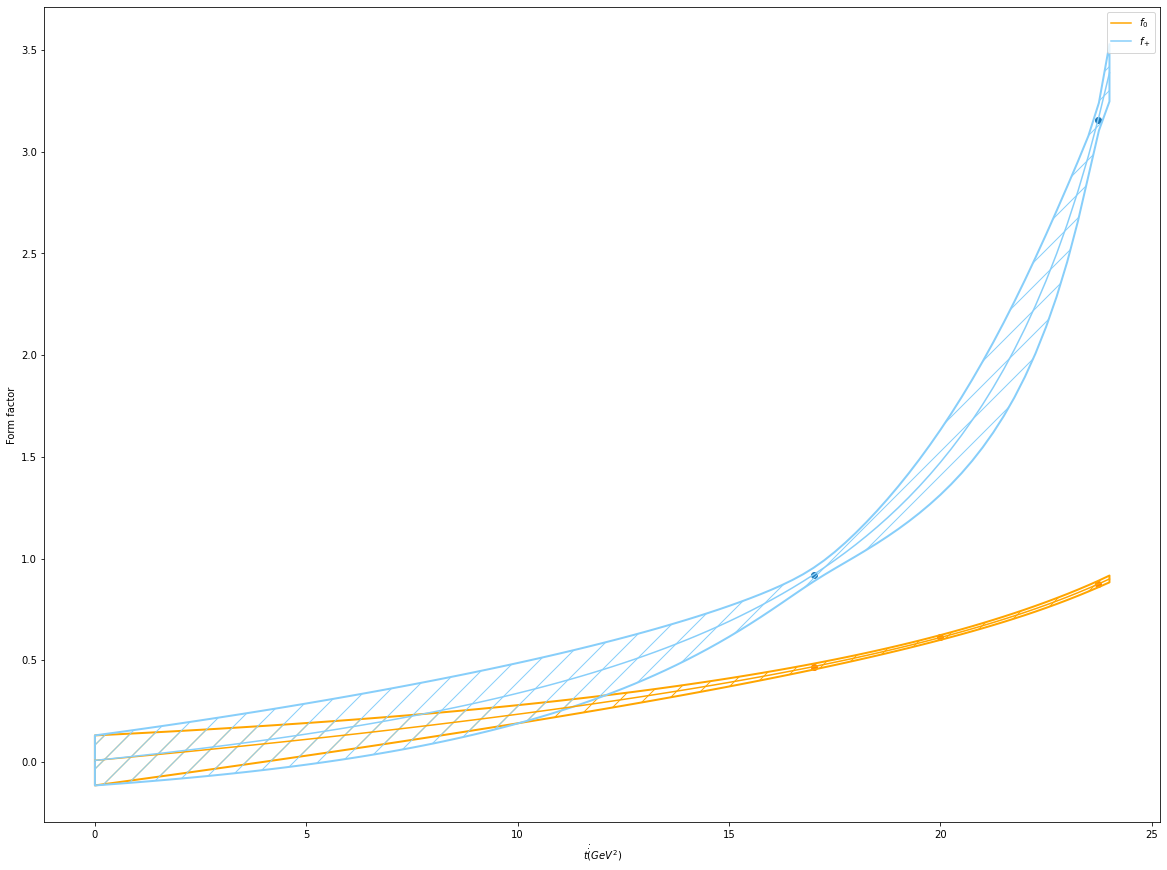

In [39]:
final = calcbounds(output)
tvals = final[0]
f0vals = final[1]
f0vars = final[2]
fplusvals = final[3]
fplusvars = final[4]

plt.rcParams["figure.figsize"] = (20,15)

plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])
plt.plot(tvals,f0vals,label = r"$f_0$",color="orange")
plt.fill_between(tvals,f0vals-f0vars,f0vals+f0vars,linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(tvals,fplusvals,label = r"$f_+$",color="lightskyblue")
plt.fill_between(tvals,fplusvals-fplusvars,fplusvals+fplusvars,linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.show()

In [35]:
# final

In [35]:
# returnsdatacheck = dispbounds([17.5,21.15623588,23.72835562],1000,N0=10)

In [36]:
# calcbounds(returnsdatacheck)

In [37]:
# %pip install line_profiler

In [38]:
# %load_ext line_profiler

In [39]:
# from scipy.optimize import *

In [40]:
# %lprun -f formfactor formfactor([np.array([[23.5       ,  0.86792049],[21.5       ,  0.71390576],[17.5       ,  0.49087795],[ 0.        , -0.0745267 ]]), np.array([[23.5       ,  3.06101327],[17.5       ,  1.04850892],[ 0.        , -0.0745267 ]])], 0.0,dindex = [0])

In [41]:
timelist = [0,5,10,15]#np.linspace(0,maxplott,49)##[17.5,21.15623588,23.72835562]
NBootstraps = 2000
output = dispbounds(timelist,NBootstraps,N0=2)

100%|██████████| 2000/2000 [01:00<00:00, 33.09it/s]


In [46]:
calcbounds(output)

[array([ 0.,  5., 10., 15.]),
 array([0.00331596, 0.10787708, 0.2325753 , 0.39033727]),
 array([0.12244292, 0.07972475, 0.04420294, 0.01984284]),
 array([0.00331596, 0.13353737, 0.33531855, 0.69010672]),
 array([0.12244311, 0.14988144, 0.14823027, 0.07557935])]

In [43]:
timelist2 = [0,5,10,15]#np.linspace(0,maxplott,49)##[17.5,21.15623588,23.72835562]
NBootstraps2 = 2000
output2 = dispbounds(timelist2,NBootstraps2,N0=None)

100%|██████████| 2000/2000 [18:58<00:00,  1.76it/s]


In [44]:
calcbounds(output2)

[array([ 0.,  5., 10., 15.]),
 array([0.00520718, 0.10940723, 0.23372359, 0.39109247]),
 array([0.12335584, 0.0805838 , 0.04491933, 0.02006875]),
 array([0.00520719, 0.13536229, 0.33704204, 0.69165965]),
 array([0.12335603, 0.15043357, 0.14851769, 0.07548561])]

In [150]:
# timelist = [0,5,10,15]#np.linspace(0,maxplott,49)##[17.5,21.15623588,23.72835562]
# NBootstraps = 20*2000
# output = dispbounds(timelist,NBootstraps,N0=2)

In [151]:
# calcbounds(output)